In [11]:
import os
from tqdm.notebook import tqdm
from deepmusic import MusicRepr, Constants
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import pickle

tqdm.pandas()

In [3]:
const = Constants(unit=4, num_tempo_bins=20, num_velocity_bins=20)
path = '/home/soroosh/data/MIDI/lmd_processed/'
files = list(filter(lambda x: x.endswith('.mid'), os.listdir(path)))
len(files)

22945

In [54]:
def process_file(file):
    seq = MusicRepr.from_file(path + file, const=const)
    tracks = seq.separate_tracks()
    ent = {'file' : file, 'n_bar': seq.get_bar_count()}
    for inst in const.instruments:
        if inst in tracks:
            ent[inst] = len(tracks[inst])
        else:
            ent[inst] = 0
    return ent
    
res = Parallel(n_jobs=20)(delayed(process_file)(file) for file in tqdm(files))

In [26]:
df = pd.DataFrame(res)
df = df.sort_values('n_bar').reset_index(drop=True)
df.head()

,file,n_bar,piano,percussion,organ,guitar,bass,strings,ensemble,brass,reed,pipe,synth-lead,synth-pad,synth-effects,ethnic,percussive,sound-effects,drums
0,845142e563abf25fc6e2bbd14243657b.mid,7,461,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,cc9046a014b743c01ea86394b6e106d3.mid,8,178,0,0,0,52,0,58,0,52,0,0,0,0,0,0,0,168
2,ad6b632b41263603dd46b2d609e898ca.mid,8,83,0,0,127,0,0,29,0,0,72,0,0,0,0,15,0,278
3,c4ae8c97333e806dda55b92a18b75024.mid,9,80,0,0,0,55,0,51,0,0,0,0,0,101,0,0,0,209
4,367d0f4718ba4e3dd28c5674bcc78dfc.mid,10,538,0,0,0,261,0,0,0,0,0,0,0,0,0,0,0,398


In [10]:
df.to_csv('lmd_data.csv', index=False)

## customize for training

In [8]:
df2 = df[(df.piano > 0) & (df.guitar > 0) & (df.drums > 0)]
df2 = df2[['file', 'n_bar', 'piano', 'guitar', 'drums']]
df2.head()

,file,n_bar,piano,guitar,drums
2,4fb43d0e8e8d263a5c97a797d8343a08.mid,405,7954,4696,9507
20,5dd4427d17c9f72d41231ac40337f30b.mid,306,1691,897,1997
23,c301629e57f9a052b783601de8c43d45.mid,304,3077,3176,8252
29,9b00e3e07949ddb99638f4cf0c0a914c.mid,292,697,3243,4786
33,1a2edb832812beeaab257acf69e2c7f1.mid,291,1830,11698,4970


In [55]:
df2['sum_events'] = df2.progress_apply(lambda x: x['piano'] + x['guitar'] + x['drums'], axis=1)
df2['piano_frac'] = df2.progress_apply(lambda x: x['piano']/ x['sum_events'], axis=1)
df2['guitar_frac'] = df2.progress_apply(lambda x: x['guitar']/ x['sum_events'], axis=1)
df2['drums_frac'] = df2.progress_apply(lambda x: x['drums']/ x['sum_events'], axis=1)
df2['avg_event_per_bar'] = df2.progress_apply(lambda x: x['sum_events']/x['n_bar'], axis=1)
df2.head()

  0%|          | 0/11131 [00:00<?, ?it/s]

  0%|          | 0/11131 [00:00<?, ?it/s]

  0%|          | 0/11131 [00:00<?, ?it/s]

  0%|          | 0/11131 [00:00<?, ?it/s]

  0%|          | 0/11131 [00:00<?, ?it/s]

,file,n_bar,piano,guitar,drums,sum_events,piano_frac,guitar_frac,drums_frac,avg_event_per_bar
2,4fb43d0e8e8d263a5c97a797d8343a08.mid,405,7954,4696,9507,22157,0.358984,0.211942,0.429074,54.708642
20,5dd4427d17c9f72d41231ac40337f30b.mid,306,1691,897,1997,4585,0.368811,0.195638,0.435551,14.983660
23,c301629e57f9a052b783601de8c43d45.mid,304,3077,3176,8252,14505,0.212134,0.218959,0.568907,47.713816
29,9b00e3e07949ddb99638f4cf0c0a914c.mid,292,697,3243,4786,8726,0.079876,0.371648,0.548476,29.883562
33,1a2edb832812beeaab257acf69e2c7f1.mid,291,1830,11698,4970,18498,0.098930,0.632393,0.268678,63.567010


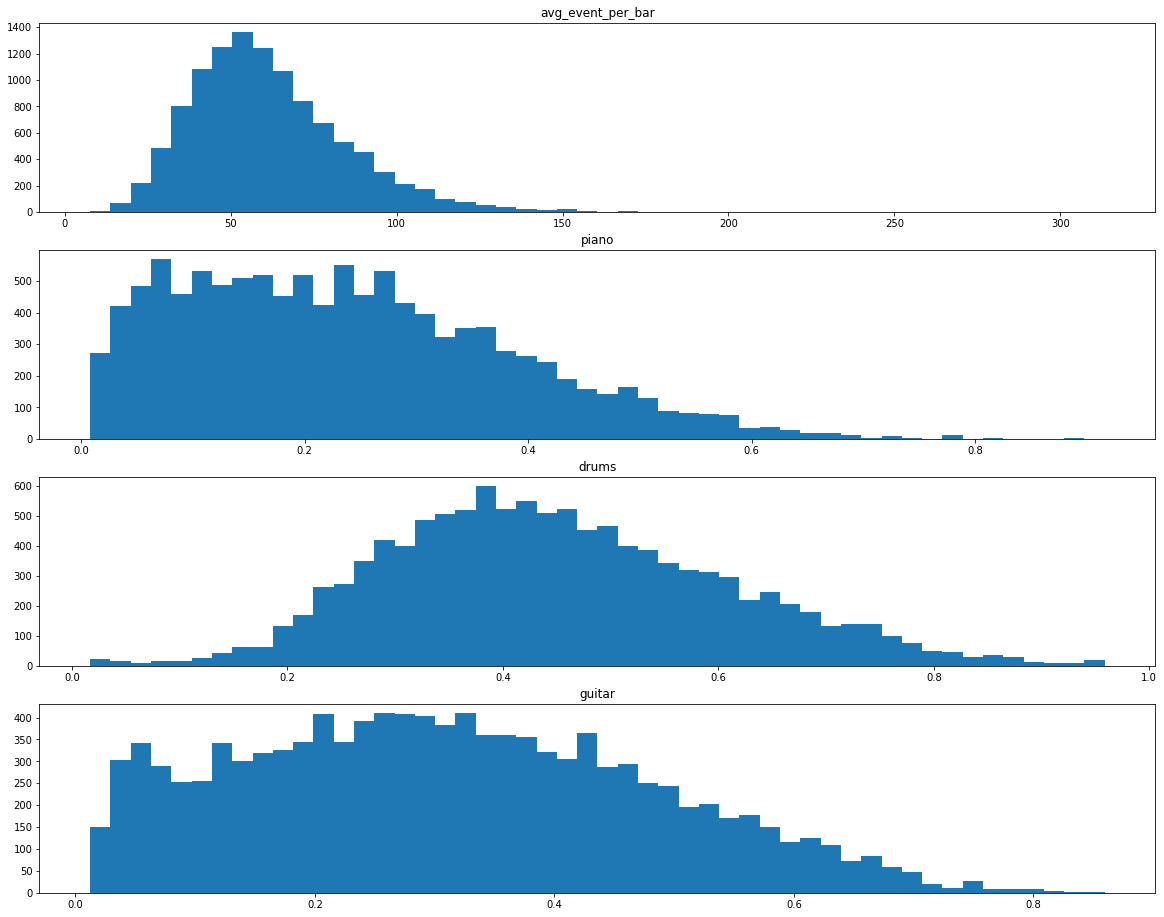

In [46]:
plt.figure(figsize=(20,16))
plt.subplot(4,1,1)
plt.title('avg_event_per_bar')
plt.hist(df2.avg_event_per_bar, 50)
plt.subplot(4,1,2)
plt.title('piano')
plt.hist(df2.piano_frac, 50)
plt.subplot(4,1,3)
plt.title('drums')
plt.hist(df2.drums_frac, 50)
plt.subplot(4,1,4)
plt.title('guitar')
plt.hist(df2.guitar_frac, 50)
plt.show()

In [56]:
df3 = df2[df2.avg_event_per_bar < 100]
df3 = df3[(df3.piano_frac > 0.25) & (df3.guitar_frac > 0.25) & (df3.drums_frac > 0.25)]
df3.shape

(1468, 10)

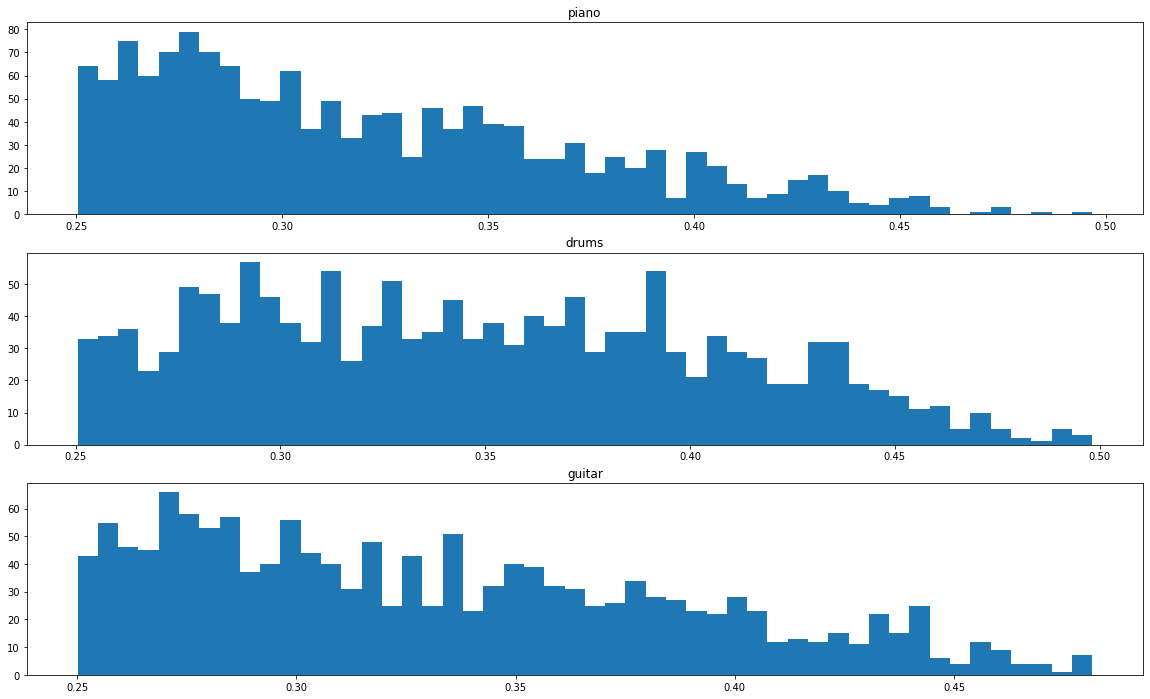

In [57]:
plt.figure(figsize=(20,12))
plt.subplot(3,1,1)
plt.title('piano')
plt.hist(df3.piano_frac, 50)
plt.subplot(3,1,2)
plt.title('drums')
plt.hist(df3.drums_frac, 50)
plt.subplot(3,1,3)
plt.title('guitar')
plt.hist(df3.guitar_frac, 50)
plt.show()

In [58]:
files = df_filtered.file.to_list()
pickle.dump(files, open('files.pkl', 'wb'))